# 数据生成

若直接采用实际数据进行流形学习，会有两个问题：
- 没有ground truth，无法判断学习的效果
- 普适性受限，算法可能只对某个蛋白质有效

所以需要自己生成蛋白质的模型（不用太精确，与假设相符即可）：
- 有ground truth可以参考
- 数量可控、信噪比可控、形态多样性可以保证
- 可以按照知识逐步精细化模型

## 蛋白质的建模

### 建模思路

科学出版社出了一本书叫《蛋白质模拟的多尺度方法》，是很多蛋白质模拟方法的论文的合集。所谓蛋白质模拟，就是在已知蛋白质序列的情况下，尽可能找到蛋白质的最小能量构象（一般认为最小能量构象是自然构象）。

我们的目的不是从序列构造出蛋白质的真实构象，而是模拟出某种统计特性上与“蛋白质”类似的东西。

书中的蛋白质模拟方法是可以借鉴的，从粗精度到细精度分别为：
- 把蛋白质当成是随机游走链（把每个残基当成一个球）
- 把20种残基的模型给出来，仍用随机游走链来模拟，每一步之间的夹角是固定的（由残基给定），把球替换成残基
- 在随机游走的时候引入禁忌搜索，防止链互相穿透
- 通过模拟退火等方法，逼近最低能量态（非常困难）

作为最初步的考虑，采用**随机游走模型**模拟蛋白质：
- 每个球的电子云密度都设为高斯函数，方差是随机出来的
- 球与球之间的距离大概是两倍球直径，方向随机

### 效果


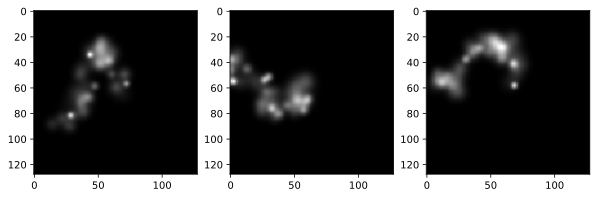

In [59]:
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

'''
uniformly sample from (dim-1) dimension unit sphere in (dim) dimension space
args:
    number: number to sample
    dim:    space dimensiion
returns:
    a (num,3) vector of the sampling results, each row represents the coordinates of a sampling point.
'''
def random_dir(number,dim = 3):
    arr = np.random.randn(number,dim)
    radius = np.sqrt(np.sum(arr * arr,axis = 1))
    return (arr.T / radius).T

'''
generate some step lengths in terms of Gaussian distribution
args:
    number:   number of step
    average:  the expectation of lengths
    variance: the Variance of lengths
returns:
    a (number,) vector representing step_lengths
'''
def random_step_length(number,average=1,variance=0.3):
    length = average+np.random.randn(number)*variance
    return length

'''
generate some radius in terms of Gaussian distribution
args:
    number:   number of radius
    average:  the expectation of radius
    variance: the Variance of radius
returns:
    a (number,) vector representing radius
'''
def random_radius(number,average=0.4,variance=0.1):
    radius = abs(average+np.random.randn(number)*variance)
    return radius

'''
generate a random train by specific dirs  generator and steplength generator
args:
    number:      the number of nodes in the chain
    dirs_gen:    the function to randomly generate the directions from a node to the next node
    lengths_gen: the function to randomly generate the lengths between adjacent nodes
    radius_gen:  the function to randomly generate radius of the nodes in chain
returns:
    the random chain, its a list of namedtuple, each item of the list is a tuple, including coordinate
        and radius
'''
Chain = namedtuple('Chain',['ps','rs'])
def random_chain(number,dirs_gen = random_dir,lengths_gen = random_step_length,radius_gen = random_radius):
    dirs = dirs_gen(number)
    step = lengths_gen(number)
    chain = Chain(np.cumsum((step*dirs.T).T,axis=0),radius_gen(number))
    return chain

def random_angle(number):
    return np.random.random(number)*np.pi

Projection = namedtuple('Projection',['ps','rs'])
def project(chain,direction,theta=0):
    direction = direction/np.sqrt(direction.dot(direction))
    tx = np.zeros_like(direction)
    tx[np.argmin(abs(direction))] = 1
    tx -= direction[np.argmin(abs(direction))]*direction
    tx = tx/np.sqrt(tx.dot(tx))
    ty = np.cross(direction,tx)
    t = np.vstack((tx,ty))
    coord = chain.ps.dot(t.T)
    coord = np.vstack((coord[:,0]*np.cos(theta)-coord[:,1]*np.sin(theta),(coord[:,0]*np.sin(theta)+coord[:,1]*np.cos(theta)))).T
    return Projection(coord,chain.rs)

def draw(projection,size=5,sample_num=51):
    x = np.linspace(-size,size,sample_num)
    y = np.linspace(-size,size,sample_num)
    xv,yv = np.meshgrid(x,y)
    vmap = np.zeros_like(xv)
    num = projection.rs.shape[0]
    for iter in range(num):
        vmap+=(1./2./np.pi/np.power(projection.rs[iter],2))*np.exp((-np.power(xv-projection.ps[iter,0],2)-np.power(yv-projection.ps[iter,1],2))/2./np.power(projection.rs[iter],2))
    vmap*=np.power(2*size/(sample_num-1),2)
    return vmap

def demo(p):
    NUMBER = 50
    chain = random_chain(NUMBER)
    proj = project(chain,np.array([1,0,0]),0)
    vmap = draw(proj,size=7,sample_num=128)
    #uplim=0.5
    #vmap[vmap>uplim]=uplim
    p.imshow(vmap,cmap='gray')

fig = plt.figure(figsize=(10,4))
sp=fig.add_subplot(131)
demo(sp)
sp=fig.add_subplot(132)
demo(sp)
sp=fig.add_subplot(133)
demo(sp)

## 构象变化模拟

### 思路

《蛋白质模拟的多尺度方法》一书中，在搜索最低能量态的时候，认为残基之间的距离及残基中的键角是不会变的（因为是共价键，强度很高），但是可能会发生旋转，所以模拟退火的每一步采样都是某个键上发生旋转。

这个方法启发就是我们可以认为构象变化都是由于键上的旋转引起的。只考虑单链的情况，此时某个键旋转相当于对那个键之后的子链进行一次旋转。

暂时想到的对构象变化的从粗精度到细精度的模拟方法是：
- 随意挑选某个键，产生旋转，其他部分一律不变
- 对整条链上的每个键都产生一定的旋转，这个旋转的角度呈现窄带高斯过程（防止变化太快）
- 如果蛋白质模型引入了高级结构的概念（$\alpha$螺旋，$\beta$折叠甚至更高级的功能区域），则可以把高级结构作为一个整体，只考虑整个结构的旋转

现在仍然采用最简单的一种，挑选某个键进行旋转。

仔细思考一下，这个方法跟转换视角是一致的，所以直接采用更简单的转换视角的方式来生成数据。

### 效果展示

0.2966016530461865


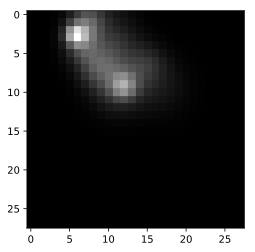

In [51]:
NUMBER = 13
chain = random_chain(NUMBER)
proj = project(chain,np.array([1,0,0]),0)
vmap = draw(proj,size=3,sample_num=28)
print(np.max(vmap))
uplim=0.5
vmap[vmap>uplim]=uplim
plt.imshow(vmap,cmap='gray')

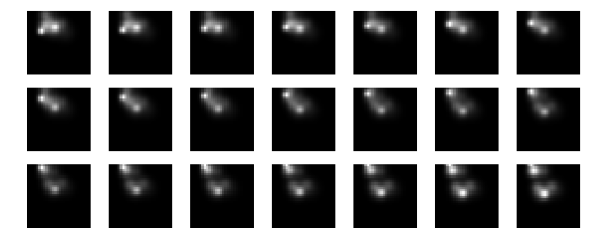

In [52]:
fig = plt.figure(figsize=(10,4))
img_len = 28
imgs = np.zeros((21,img_len,img_len))
for k in range(-10,11):
    sp = fig.add_subplot(3,7,k+11)
    sp.axis('off')
    proj = project(chain,np.array([1,0,k/20]),0)
    vmap = draw(proj,size=3,sample_num=img_len)
    sp.imshow(vmap,cmap='gray')
    imgs[k+10,:,:] = vmap

# 流形学习效果展示

将上述生成的21个图像，每个复制20份，共210张图像，给这些图像分别加上独立的高斯噪声，用之前所说的各种流形学习方法学习，观察分类效果。


In [53]:
import numpy as np
import sklearn
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
copy_rate = 20
img_num = 21*copy_rate
img_size = (img_len,img_len)
X0 = np.zeros((img_num,img_len*img_len))
y = np.zeros(img_num,dtype=np.uint8)
for k in range(img_num):
    X0[k,:] = imgs[int(k/copy_rate),:,:].reshape(-1)
    y[k] = int(k/copy_rate)
E = np.sum(np.square(X0[:,:]))/img_num
print('total_energy',E)


total_energy 1.3234115048222128



Manifold learning : Locally Linear Embedding series

Computing PCA projection
Computing Isomap embedding
Done.
Computing LLE embedding
Done. Reconstruction error: 0.234063
Computing modified LLE embedding
Done. Reconstruction error: 2.44615
Computing MDS embedding
Done. Stress: 168428.845622
Computing Spectral embedding


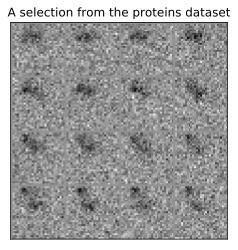

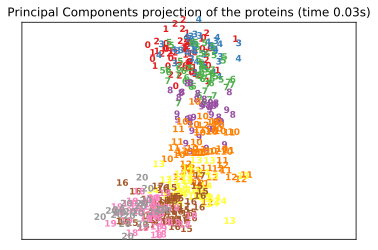

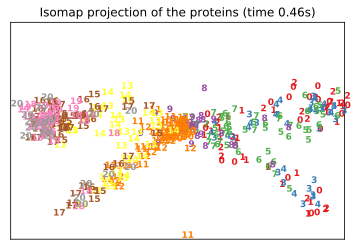

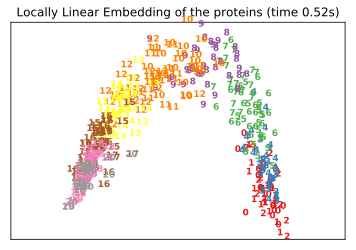

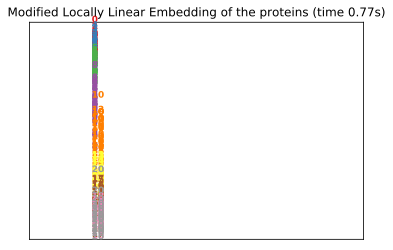

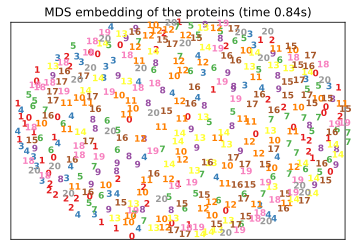

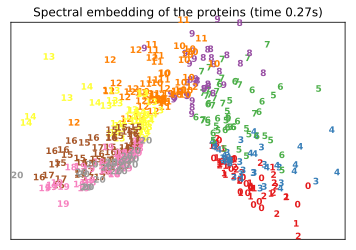

In [60]:
'''
=============================================================================
Manifold learning : Locally Linear Embedding series
=============================================================================
'''

print(__doc__)
from time import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

SNR = 0.5
ne = np.sqrt(E/(img_len*img_len))/SNR
X = X0 + np.random.randn(img_num,img_len**2)*ne
#digits = datasets.load_digits(n_class=6)
#X = digits.data
#y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30
n_dim = 2


#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    X = X.squeeze()
    x_min, x_max = np.min(X), np.max(X)
    X = (X - x_min) / (x_max - x_min)
    
    if len(X.shape) == 1:
        X = np.array([X,np.ones_like(X)/2]).T

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 22.),
                 fontdict={'weight': 'bold', 'size': 9})

    #if hasattr(offsetbox, 'AnnotationBbox'):
    if False:
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)


#----------------------------------------------------------------------
# Plot images of the digits

n_img_per_row = 4
img = np.zeros(((img_len+1) * n_img_per_row, (img_len+1) * n_img_per_row))
for i in range(n_img_per_row):
    ix = (img_len+1) * i + 1
    for j in range(n_img_per_row):
        iy = (img_len+1) * j + 1
        img[ix:ix + img_len, iy:iy + img_len] = X[(i * n_img_per_row + j)*20].reshape((img_len,img_len))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the proteins dataset')

#----------------------------------------------------------------------
# Random 2D projection using a random unitary matrix
#print("Computing random projection")
#rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)
#X_projected = rp.fit_transform(X)
#plot_embedding(X_projected, "Random Projection of the proteins")


#----------------------------------------------------------------------
# Projection on to the first 2 principal components

print("Computing PCA projection")
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
X_pca -= np.mean(X_pca,axis=0)
plot_embedding(X_pca,
               "Principal Components projection of the proteins (time %.2fs)" %
               (time() - t0))

#----------------------------------------------------------------------
# Projection on to the first 2 linear discriminant components

#print("Computing Linear Discriminant Analysis projection")
#X2 = X.copy()
#X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
#t0 = time()
#X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2).fit_transform(X2, y)
#plot_embedding(X_lda,
#               "Linear Discriminant projection of the proteins (time %.2fs)" %
#               (time() - t0))


#----------------------------------------------------------------------
# Isomap projection of the digits dataset
print("Computing Isomap embedding")
t0 = time()
X_iso = manifold.Isomap(n_neighbors, n_components=n_dim).fit_transform(X)
print("Done.")
plot_embedding(X_iso,
               "Isomap projection of the proteins (time %.2fs)" %
               (time() - t0))


#----------------------------------------------------------------------
# Locally linear embedding of the digits dataset
print("Computing LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=n_dim,
                                      method='standard')
t0 = time()
X_lle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_lle,
               "Locally Linear Embedding of the proteins (time %.2fs)" %
               (time() - t0))


#----------------------------------------------------------------------
# Modified Locally linear embedding of the digits dataset
print("Computing modified LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=n_dim,
                                      method='modified')
t0 = time()
X_mlle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_mlle,
               "Modified Locally Linear Embedding of the proteins (time %.2fs)" %
               (time() - t0))


#----------------------------------------------------------------------
# HLLE embedding of the digits dataset
#print("Computing Hessian LLE embedding")
#clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
#                                      method='hessian')
#t0 = time()
#X_hlle = clf.fit_transform(X)
#print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
#plot_embedding(X_hlle,
#               "Hessian Locally Linear Embedding of the proteins (time %.2fs)" %
#               (time() - t0))


#----------------------------------------------------------------------
# LTSA embedding of the digits dataset
#print("Computing LTSA embedding")
#clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=n_dim,
#                                      method='ltsa')
#t0 = time()
#X_ltsa = clf.fit_transform(X)
#print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
#plot_embedding(X_ltsa,
#               "Local Tangent Space Alignment of the proteins (time %.2fs)" %
#               (time() - t0))

#----------------------------------------------------------------------
# MDS  embedding of the digits dataset
print("Computing MDS embedding")
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)
t0 = time()
X_mds = clf.fit_transform(X)
print("Done. Stress: %f" % clf.stress_)
plot_embedding(X_mds,
               "MDS embedding of the proteins (time %.2fs)" %
               (time() - t0))

#----------------------------------------------------------------------
# Random Trees embedding of the digits dataset
#print("Computing Totally Random Trees embedding")
#hasher = ensemble.RandomTreesEmbedding(n_estimators=200, random_state=0,
#                                       max_depth=5)
#t0 = time()
#X_transformed = hasher.fit_transform(X)
#pca = decomposition.TruncatedSVD(n_components=2)
#X_reduced = pca.fit_transform(X_transformed)

#plot_embedding(X_reduced,
#               "Random forest embedding of the proteins (time %.2fs)" %
#               (time() - t0))

#----------------------------------------------------------------------
# Spectral embedding of the digits dataset
print("Computing Spectral embedding")
embedder = manifold.SpectralEmbedding(n_components=2, random_state=0,
                                      eigen_solver="arpack")
t0 = time()
X_se = embedder.fit_transform(X)

plot_embedding(X_se,
               "Spectral embedding of the proteins (time %.2fs)" %
               (time() - t0))

#----------------------------------------------------------------------
# t-SNE embedding of the digits dataset
#print("Computing t-SNE embedding")
#tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
#t0 = time()
#X_tsne = tsne.fit_transform(X)

#plot_embedding(X_tsne,
#               "t-SNE embedding of the digits (time %.2fs)" %
#               (time() - t0))

'''

'''
plt.show()

## 非传统算法

NLPCA（非线性PCA）、AutoEncoder（自动编码器）等基于Deaplearning的方法，虽然结果可能更好看，但是缺乏可解释性，可以考虑，但是需要好好思考怎么用上流形的信息。
